- 오늘은 해외 축구 선수 이적료 예측 미션을 Pycaret을 이용하여 모델링을 해보았습니다

In [1]:
# 현재 작업 경로를 얻는 함수
import os
print(os.getcwd())

C:\Users\hu612\Downloads


In [2]:
import pandas as pd

train = pd.read_csv("FIFA_train.csv")
test = pd.read_csv("FIFA_test.csv")
submission = pd.read_csv("submission.csv")

In [3]:
print(train.shape)
print(test.shape)
print(submission.shape)

(8932, 12)
(3828, 11)
(3828, 2)


### **train 열**
- id : 선수 고유의 아이디
- name : 이름
- age : 나이
- continent : 선수들의 국적이 포함되어 있는 대륙입니다.
- contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다.
- position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
- prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
- reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
- stat_overall : 선수의 현재 능력치 입니다.
- stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
- stat_skill_moves : 선수의 개인기 능력치 입니다.
- value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.

**-> 11가지의 columns를 이용하여 value를 예측하는 문제입니다. train.csv 파일을 이용하여 모형을 학습하고 test.csv 파일을 적용시켜 예측된 value를 제출하면 됩니다.**

### **전처리**

- 먼저 베이스라인처럼 id와 name columns는 불필요하다고 생각이 되어 삭제를 합니다.

In [4]:
train.drop(['id', 'name'], axis = 1, inplace = True)
test.drop(['id', 'name'], axis = 1, inplace = True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   object 
 2   contract_until    8932 non-null   object 
 3   position          8932 non-null   object 
 4   prefer_foot       8932 non-null   object 
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 697.9+ KB


In [6]:
train.isnull().sum()

age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [7]:
train.head(3)

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0


In [8]:
len(train.columns)

10

In [9]:
for i in range(len(train.columns)):
    print(train.columns[i], ":", type(train[train.columns[i]][0]))

age : <class 'numpy.int64'>
continent : <class 'str'>
contract_until : <class 'str'>
position : <class 'str'>
prefer_foot : <class 'str'>
reputation : <class 'numpy.float64'>
stat_overall : <class 'numpy.int64'>
stat_potential : <class 'numpy.int64'>
stat_skill_moves : <class 'numpy.float64'>
value : <class 'numpy.float64'>


- train 데이터에 대하여 각 변수의 종류, 유형을 살펴보고 전처리를 진행합니다.


#### **age**

In [10]:
print(train.age.max())
print(train.age.min())
print(train.age.mean())

40
16
25.209135691894314


In [11]:
train['age'].value_counts()

26    708
24    691
21    676
23    663
25    654
22    632
20    582
27    581
28    532
19    491
30    476
29    472
31    347
18    344
32    285
34    216
33    202
17    131
35     89
36     64
37     42
16     18
38     17
39     16
40      3
Name: age, dtype: int64

[]

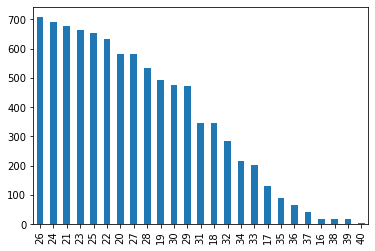

In [12]:
import matplotlib.pyplot as plt
plt.figure()
train.age.value_counts().plot(kind='bar')
plt.plot()

#### **continent**

In [ ]:
train['continent'].value_counts()

In [ ]:
test['continent'].value_counts()

- continent columns는 선수들의 국적 5가지가 표기되어 있었습니다. 
- 문자열을 숫자로 치환해주고 나중에 정규화를 해주겠습니다.

In [ ]:
train['continent'] = train['continent'].replace('europe',1)
train['continent'] = train['continent'].replace('south america',2)
train['continent'] = train['continent'].replace('asia',3)
train['continent'] = train['continent'].replace('africa',4)
train['continent'] = train['continent'].replace('oceania',5)

In [ ]:
test['continent'] = test['continent'].replace('europe',1)
test['continent'] = test['continent'].replace('south america',2)
test['continent'] = test['continent'].replace('asia',3)
test['continent'] = test['continent'].replace('africa',4)
test['continent'] = test['continent'].replace('oceania',5)

#### **contract_until**

In [ ]:
train['contract_until'].value_counts()

In [ ]:
test['contract_until'].value_counts()

- 계약 연도에 관해 나타내져 있는 columns입니다. 보면 계약 연도만 있는 경우도 있고 언제까지인지 나타나져 있는 경우도 있습니다.
- 통일을 위해 계약 연도만 추출하여 표시해주도록 하겠습니다.

In [ ]:
def year(x):
  x = x[-4:]
  return int(x)

train['contract_until'] = train['contract_until'].apply(year)
test['contract_until'] = test['contract_until'].apply(year)

In [ ]:
train['contract_until'].value_counts()

In [ ]:
test['contract_until'].value_counts()

#### **position**

In [ ]:
train['position'].value_counts()

In [14]:
test['position'].value_counts()

MF    1431
DF    1270
ST     717
GK     410
Name: position, dtype: int64

- position columns도 문자열이기 때문에 먼저 숫자로 치환해주겠습니다.

In [15]:
train['position'] = train['position'].replace('MF',1)
train['position'] = train['position'].replace('DF',2)
train['position'] = train['position'].replace('ST',3)
train['position'] = train['position'].replace('GK',4)

In [16]:
test['position'] = test['position'].replace('MF',1)
test['position'] = test['position'].replace('DF',2)
test['position'] = test['position'].replace('ST',3)
test['position'] = test['position'].replace('GK',4)

#### **prefer_foot**

In [17]:
train['prefer_foot'].value_counts()

right    6837
left     2095
Name: prefer_foot, dtype: int64

In [18]:
train['prefer_foot'] = train['prefer_foot'].replace('right',1)
train['prefer_foot'] = train['prefer_foot'].replace('left',2)

In [19]:
test['prefer_foot'] = test['prefer_foot'].replace('right',1)
test['prefer_foot'] = test['prefer_foot'].replace('left',2)

#### **reputation**

In [20]:
train['reputation']

0       5.0
1       4.0
2       5.0
3       4.0
4       3.0
       ... 
8927    1.0
8928    1.0
8929    1.0
8930    1.0
8931    1.0
Name: reputation, Length: 8932, dtype: float64

In [21]:
train['reputation'] = train['reputation'].astype(int)
test['reputation'] = test['reputation'].astype(int)

In [22]:
train['reputation']

0       5
1       4
2       5
3       4
4       3
       ..
8927    1
8928    1
8929    1
8930    1
8931    1
Name: reputation, Length: 8932, dtype: int32

#### **stat_overall, stat_potential**

In [23]:
train['stat_overall'].value_counts()[:5]

67    570
66    559
68    543
69    532
64    492
Name: stat_overall, dtype: int64

In [24]:
train['stat_potential'].value_counts()[:5]

72    613
70    612
71    594
69    575
73    554
Name: stat_potential, dtype: int64

- age columns와 함께 정규화 작업을 해줄거라서 일단 넘어가겠습니다.

#### **stat_skill_moves**

In [25]:
train['stat_skill_moves'].value_counts()

2.0    3905
3.0    3473
1.0    1008
4.0     515
5.0      31
Name: stat_skill_moves, dtype: int64

In [26]:
test['stat_skill_moves'].value_counts()

2.0    1700
3.0    1451
1.0     410
4.0     254
5.0      13
Name: stat_skill_moves, dtype: int64

In [27]:
train['stat_skill_moves'] = train['stat_skill_moves'].astype(int)
test['stat_skill_moves'] = test['stat_skill_moves'].astype(int)

#### **age, stat_overall, stat_potential 정규화**

In [28]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
mm = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
mm.fit(train[['age','stat_overall','stat_potential']])
train_ass = mm.transform(train[['age','stat_overall','stat_potential']])

In [29]:
train_ass = pd.DataFrame(train_ass)
train_ass.shape

(8932, 3)

In [30]:
del train['age']
del train['stat_overall']
del train['stat_potential']

In [31]:
train.shape

(8932, 7)

In [32]:
train = pd.concat([train_ass, train], axis = 1)
train.shape

(8932, 10)

In [33]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
mm = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
mm.fit(test[['age','stat_overall','stat_potential']])
test_ass = mm.transform(test[['age','stat_overall','stat_potential']])

In [34]:
test_ass = pd.DataFrame(test_ass)
test_ass.shape

(3828, 3)

In [35]:
del test['age']
del test['stat_overall']
del test['stat_potential']

In [36]:
test = pd.concat([test_ass, test], axis = 1)
test.shape

(3828, 9)

### **모델링**

In [38]:
from pycaret.regression import *

df = setup(data = train, target = 'value',train_size=0.8, session_id = 123)

,Description,Value
0,session_id,123
1,Target,value
2,Original Data,"(8932, 10)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(7145, 27)"


In [39]:
best = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,41051.5440,71866056933.4822,144774.2963,0.2979,0.0495,0.0238,0.2260
gbr,Gradient Boosting Regressor,243835.5089,702146176549.3835,745109.6208,0.9825,0.3472,0.2248,0.1180
xgboost,Extreme Gradient Boosting,174113.7211,689756702310.4000,752622.0531,0.9829,0.1109,0.0661,0.4680
et,Extra Trees Regressor,184571.7104,895952472309.4324,860960.9488,0.9771,0.1078,0.0581,0.3780
rf,Random Forest Regressor,191031.1757,960944851760.8188,876791.8488,0.9757,0.1031,0.0590,0.3060
lightgbm,Light Gradient Boosting Machine,197875.9780,1255881945916.5540,981247.2426,0.9690,0.1913,0.1135,0.1450
dt,Decision Tree Regressor,249113.8296,1598879563506.0405,1192607.3951,0.9572,0.1390,0.0671,0.0180
ada,AdaBoost Regressor,1760014.2648,4727262941714.3799,2149048.5579,0.8610,1.5744,5.1251,0.1060
knn,K Neighbors Regressor,1204692.2000,11849740111052.8008,3383021.8000,0.6666,0.6408,0.7260,0.0400
llar,Lasso Least Angle Regression,1905665.5363,12296915435989.0586,3459749.3695,0.6513,1.3616,5.0774,0.0090


In [40]:
# 모델 생성하기
cat = create_model('catboost', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,221876.2195,4.374862e+11,661427.4068,0.9852,0.3315,0.2463


In [41]:
# 하이퍼파라미터 튜닝
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10)
tuned_xgb = tune_model(xgb, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(gbr, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,153749.2108,763628859204.8037,873858.6037,0.9680,0.1001,0.0625
1,166765.2055,284913195472.8517,533772.6065,0.9928,0.1279,0.0718
2,169382.7440,243751403226.5652,493711.8626,0.9947,0.1296,0.0755
3,127133.5653,242703682221.9017,492649.6546,0.9897,0.1285,0.0750
4,120719.3354,106522062336.1262,326377.1780,0.9964,0.1309,0.0664
5,126398.1307,128373959873.3477,358293.1200,0.9932,0.0931,0.0626
6,218450.0344,2143560183087.1643,1464090.2237,0.9608,0.1101,0.0558
7,205811.2487,1526574948564.4131,1235546.4170,0.9598,0.1141,0.0651
8,195976.9641,1024378249063.9382,1012115.7291,0.9763,0.0914,0.0606
9,148732.3548,296324078810.2864,544356.5732,0.9916,0.2412,0.1040


In [42]:
# 모델 블렌딩(Blend)

blender_specific = blend_models(estimator_list = 
                                [tuned_cat,tuned_xgb,tuned_gbr], optimize = 'RMSE')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,164591.1205,369539029833.9967,607897.2198,0.9845,0.1849,0.1091
1,176942.0002,263173395796.8206,513004.2844,0.9934,0.1445,0.0976
2,183114.5385,228213066018.6578,477716.5122,0.9950,0.2519,0.1127
3,126240.2647,80857617170.1863,284354.7383,0.9966,0.1538,0.1038
4,139576.0701,120600934225.3064,347276.4522,0.9959,0.1606,0.1070
5,141450.0982,109450442210.1862,330832.9521,0.9942,0.1494,0.1036
6,223508.5822,2287218011983.1177,1512355.1210,0.9582,0.1538,0.0940
7,219886.6375,1158855736325.8813,1076501.6193,0.9694,0.1708,0.1100
8,192629.7251,383321284863.9502,619129.4573,0.9911,0.1704,0.1094
9,144553.4559,179170703457.6943,423285.6051,0.9949,0.2681,0.1449


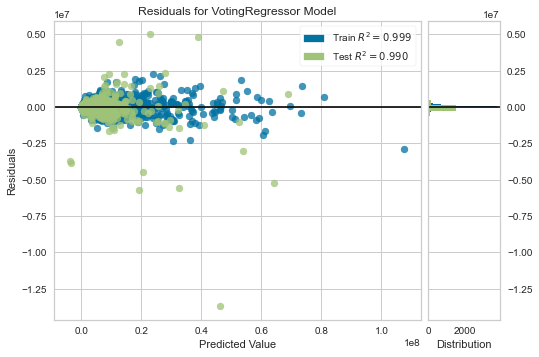

In [43]:
plot_model(blender_specific)

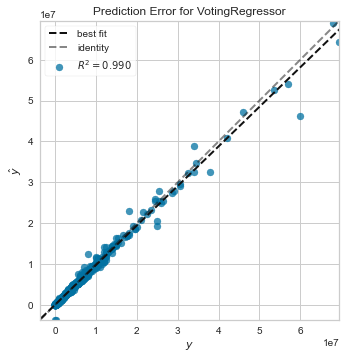

In [45]:
plot_model(blender_specific, plot='error')

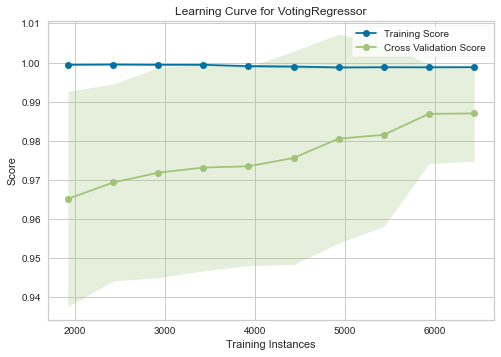

In [46]:
plot_model(blender_specific, plot='learning')

In [47]:
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

In [48]:
# 예측(Predict)
pred = predict_model(final_model, data = test)

In [51]:
pred.head(3)

,0,1,2,continent,contract_until,position,prefer_foot,reputation,stat_skill_moves,Label
0,0.653846,1.000000,0.976744,europe,2022,3,1,5,5,8.768736e+07
1,0.384615,0.957447,0.953488,south america,2022,3,1,5,5,8.941837e+07
2,0.423077,0.936170,0.930233,europe,2023,1,1,4,4,7.516293e+07


In [50]:
pred['Label']

0       8.768736e+07
1       8.941837e+07
2       7.516293e+07
3       7.428270e+07
4       6.895601e+07
            ...     
3823    1.099876e+05
3824    5.275563e+04
3825    7.444700e+04
3826    9.131228e+04
3827    7.616987e+04
Name: Label, Length: 3828, dtype: float64

In [52]:
submission['value'] = pred['Label']

In [54]:
submission.to_csv('pycaret_modeling.csv', index=False)

### [마무리]

- 다음과 같이 제출을 하면 1054169.64284점이 나옵니다.
- 우엥,, 다음주까지 성능을 좀 더 올려서 코드공유를 해보겠습니다.

### 감사합니다.

### [Reference]

[1] Pycaret 참고
https://dacon.io/codeshare/4243?dtype=recent<br>
[2] Pycaret 참고 : https://today-1.tistory.com/17